In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from utils import *

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Helvetica",
        "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}",
    }
)

In [341]:
C = 343.
RHO = 1.2

## Convergence Analysis for the Number of Elements for every Wavelength

In [343]:
# load data
data_file = pathlib.Path.cwd().joinpath("data", "plane_wave", "convergence_elements_lambda.tar.gz")
data = load_tar(data_file)

In [344]:
f = 10e+3
wave_length = C / f
k = 2 * np.pi / wave_length
d = 22e-3


def reference_plane(src: np.ndarray, k0: np.ndarray = None) -> np.ndarray:
    if k0 is None:
        k0 = np.array([k])
    return np.exp(1j * np.outer(k0, src[:, 0]))

In [345]:
n_e = []
diffs = []
geos = []
for dataset in data:
    
    indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
    geometry = dataset.x[indices, :2]
    pressure = dataset.p[:, indices]
    ground_truth = reference_plane(geometry)
    
    difference = ground_truth - pressure
    
    diffs.append(difference.squeeze())
    n_e.append(dataset.description.elements_per_lambda)
    geos.append(geometry)
n_e = np.array(n_e)
indices = np.argsort(n_e).tolist()

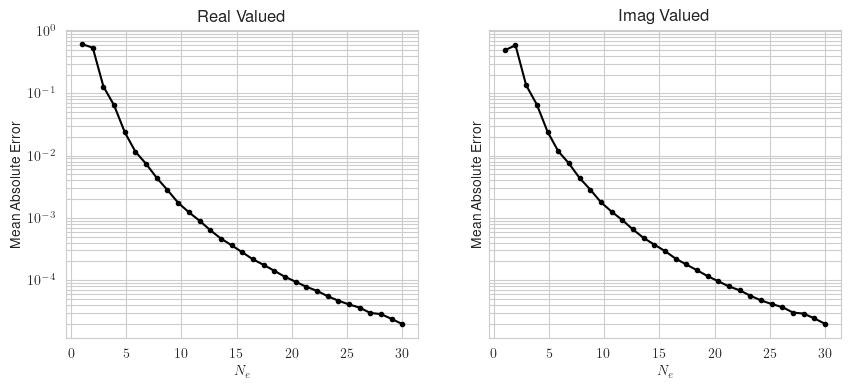

In [346]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(n_e[indices], np.array([np.mean(np.abs(np.real(diff))) for diff in diffs])[indices], 'k.-')
axs[0].title.set_text("Real Valued")
axs[1].plot(n_e[indices], np.array([np.mean(np.abs(np.imag(diff))) for diff in diffs])[indices], 'k.-')
axs[1].title.set_text("Imag Valued")
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('$N_e$')
    ax.set_ylabel('Mean Absolute Error')
    ax.xaxis.grid(True)
    ax.yaxis.grid(True, which='both')

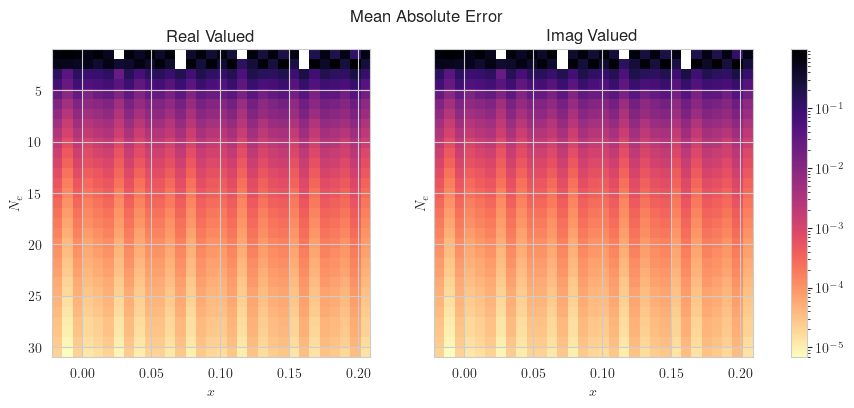

In [347]:
n_bins = 31
bins = np.linspace(-d / 2, 9.5 * d, n_bins, endpoint=False)

im_real = np.zeros((len(n_e), n_bins))
im_imag = np.zeros((len(n_e), n_bins))
for i, (geo, diff) in enumerate(zip(geos, diffs)):
    bin_indices = np.searchsorted(bins, geo[:, 0], side='right') - 1
    for ind in range(n_bins):
        bin_diff = diff[np.where(bin_indices == ind)]

        im_real[ind, i] = np.mean(np.abs(np.real(bin_diff)))
        im_imag[ind, i] = np.mean(np.abs(np.imag(bin_diff)))

# real
im_real = im_real[:, indices]
im_real = np.ma.array(im_real, mask=np.isnan(im_real))

# imag
im_imag = im_imag[:, indices]
im_imag = np.ma.array(im_imag, mask=np.isnan(im_imag))

v_max = np.nanmax(np.stack([im_real, im_imag]))

fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)

real_cmap = mpl.colormaps["magma_r"]
real_cmap.set_bad('white', 1.)

extent = [-d, 9.5 * d, 31, 1]

axs[0].imshow(im_real.T, cmap=real_cmap, interpolation='nearest', norm=mpl.colors.LogNorm(), extent=extent,
              aspect='auto')
axs[0].title.set_text("Real Valued")
im = axs[1].imshow(im_real.T, cmap='magma_r', norm=mpl.colors.LogNorm(), extent=extent, aspect='auto')
axs[1].title.set_text("Imag Valued")
fig.colorbar(im, ax=axs[:], fraction=0.046)

fig.suptitle("Mean Absolute Error")
for ax in axs:
    ax.set_ylabel('$N_e$')
    ax.set_xlabel('$x$')

## Depth of the Absorbers

In [348]:
data_file = pathlib.Path.cwd().joinpath("data", "plane_wave", "depth_adiabatic_layer.tar.gz")
data = load_tar(data_file)

In [349]:
d_a = []
diffs = []
for dataset in data:
    
    indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
    geometry = dataset.x[indices, :2]
    pressure = dataset.p[0, indices]
    ground_truth = reference_plane(geometry)
    
    difference = ground_truth - pressure
    
    diffs.append(difference)
    d_a.append(dataset.description.absorber.depth / wave_length)
d_a = np.array(d_a)
indices = np.argsort(d_a).tolist()

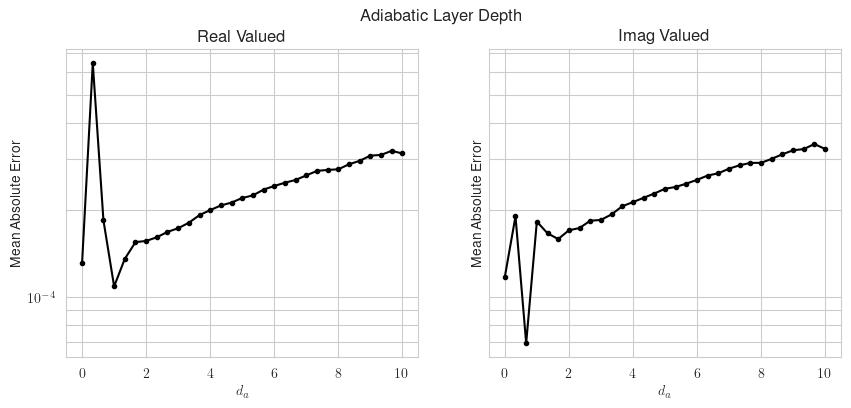

In [350]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(d_a[indices], np.array([np.mean(np.abs(np.real(diff))) for diff in diffs])[indices], 'k.-')
axs[0].title.set_text("Real Valued")
axs[1].plot(d_a[indices], np.array([np.mean(np.abs(np.imag(diff))) for diff in diffs])[indices], 'k.-')
axs[1].title.set_text("Imag Valued")

fig.suptitle("Adiabatic Layer Depth")
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('$d_a$')
    ax.set_ylabel('Mean Absolute Error')
    ax.xaxis.grid(True)
    ax.yaxis.grid(True, which='both')

## Absorber Parameters

In [351]:
data_file = pathlib.Path.cwd().joinpath("data", "plane_wave", "absorber_parameters.tar.gz")
data = load_tar(data_file)

In [352]:
d_a = []
deg = []
diffs_real = []
diffs_imag = []
for dataset in data:
    indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
    geometry = dataset.x[indices, :2]
    pressure = dataset.p[0, indices]
    ground_truth = reference_plane(geometry)

    difference = ground_truth - pressure

    diffs_real.append(np.mean(np.abs(np.real(difference))))
    diffs_imag.append(np.mean(np.abs(np.imag(difference))))
    d_a.append(dataset.description.absorber.depth / wave_length)
    deg.append(dataset.description.absorber.degree)

df = pd.DataFrame({
    "d_a": d_a,
    "Exponent": deg,
    "diffs_real": diffs_real,
    "diffs_imag": diffs_imag
})

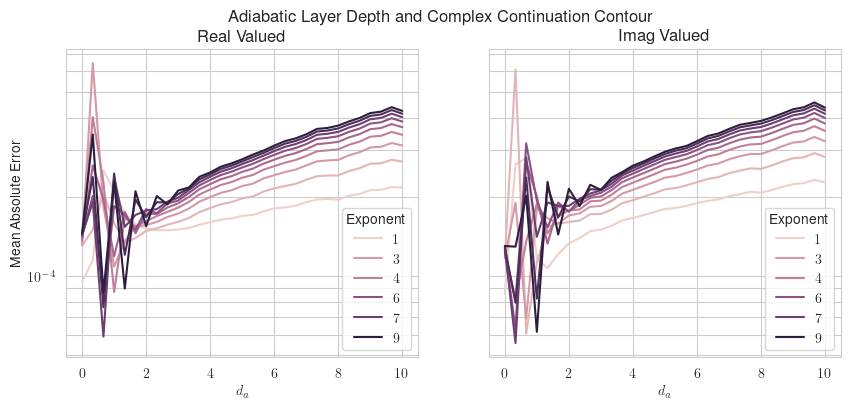

In [353]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
sns.lineplot(df, x='d_a', y='diffs_real', hue="Exponent", ax=axs[0])
axs[0].title.set_text("Real Valued")
sns.lineplot(df, x='d_a', y='diffs_imag', hue="Exponent", ax=axs[1])
axs[1].title.set_text("Imag Valued")

fig.suptitle("Adiabatic Layer Depth and Complex Continuation Contour")
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('$d_a$')
    ax.set_ylabel('Mean Absolute Error')
    ax.xaxis.grid(True)
    ax.yaxis.grid(True, which='both')

## Performance of Absorbers of constant Length

In [354]:
data_file = pathlib.Path.cwd().joinpath("data", "plane_wave", "const_absorber_depth.tar.gz")
data = load_tar(data_file)

In [355]:
dataset = data[0]

indices = (dataset.x[:, 0] <= 9.5 * 22e-3) & (dataset.x[:, 0] >= -0.5 * 22e-3)
geometry = dataset.x[indices, :2]

wave_numbers = 2 * np.pi * dataset.frequencies / C

pressure = dataset.p[:, indices]
ground_truth = reference_plane(geometry, wave_numbers)

difference = ground_truth - pressure

indices = np.argsort(dataset.frequencies)

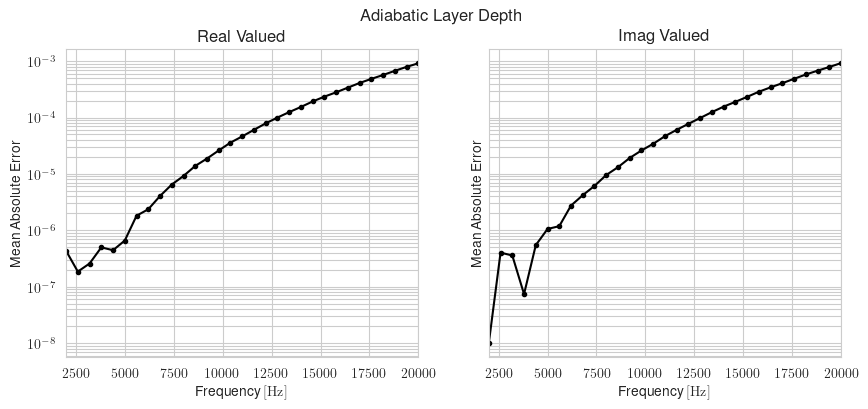

In [357]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(dataset.frequencies[indices], np.mean(np.abs(np.real(difference)), axis=1)[indices], 'k.-')
axs[0].title.set_text("Real Valued")
axs[1].plot(dataset.frequencies[indices], np.mean(np.abs(np.imag(difference)), axis=1)[indices], 'k.-')
axs[1].title.set_text("Imag Valued")

fig.suptitle("Adiabatic Layer Depth")
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Frequency $[\si{\hertz}]$ ')
    ax.set_ylabel('Mean Absolute Error')
    ax.xaxis.grid(True)
    ax.yaxis.grid(True, which='both')
    ax.set_xlim(2e+3, 20e+3)